In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import math
import imageio
import datetime
from os import walk

In [2]:
savepath = '../img/one_channel/'
start_date = datetime.date(2000, 1, 28)
end_date = datetime.date(2021, 8, 11)
delta = datetime.timedelta(days=1)

In [3]:
from os import walk

filenames = next(walk(savepath), (None, None, []))[2]  # [] if no file
filenames = filenames
filenames = filenames[:1000]

In [4]:
dataset = None
for i,file in enumerate(filenames):
    fullpath = savepath+file
    im = imageio.get_reader(fullpath)
    for frame in im:
        frame.reshape(-1,100,100)
        if dataset is None:
            dataset = frame
        else:
            dataset = np.dstack((dataset, frame))
    if i % 300 == 0:
        percent = round(i*100/len(filenames))
        print(f"{percent}%")
        
dataset = np.swapaxes(dataset, 0, 2)
dataset.shape

0%
30%
60%
90%


(1000, 100, 100)

In [5]:
dataset.shape

(1000, 100, 100)

In [6]:
batchsize = 64
#remainder = dataset.shape[0] % batchsize

In [7]:
#dataset = dataset[:remainder * -1]
#dataset.shape

In [8]:
# this would break the dataset into batches, but we don't want to do that
# instead, let's wait until we generate x_train
#batches = dataset.shape[0] / 64
#dataset = dataset.reshape(int(batchsize), int(batches), 100, 100)
dataset.shape

(1000, 100, 100)

In [9]:

dataset.shape

(1000, 100, 100)

In [10]:
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]
print(train_dataset.shape)
print(val_dataset.shape)

(900, 100, 100)
(100, 100, 100)


In [11]:
# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [12]:
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames(data):
    
    #this produces 3-d shape index, x, y
    x = data[ 0 : data.shape[0] - 1, :, :]
    y = data[ 1 : data.shape[0], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (899, 100, 100), (899, 100, 100)
Validation Dataset Shapes: (99, 100, 100), (99, 100, 100)


In [13]:
def AddEmptyChannel(x):
    x = np.expand_dims(x,axis=4)
    return x

def Batchify(arr, batchsize):
    oldshape = arr.shape
    remainder = arr.shape[0] % batchsize
    if remainder > 0:
        arr = arr[:-1 * remainder]
    print(arr.shape)
    numbatches = arr.shape[0] / batchsize
    arr = arr.reshape(int(batchsize), int(numbatches), 100, 100)
    arr = AddEmptyChannel(arr)
    print(f"{oldshape} -> {arr.shape}")
    return arr

In [14]:
7744 % 64

0

In [15]:
batchsize=64
x_train = Batchify(x_train, batchsize)
y_train = Batchify(y_train, batchsize)
x_val = Batchify(x_val, batchsize)
y_val = Batchify(y_val, batchsize)

(896, 100, 100)
(899, 100, 100) -> (64, 14, 100, 100, 1)
(896, 100, 100)
(899, 100, 100) -> (64, 14, 100, 100, 1)
(64, 100, 100)
(99, 100, 100) -> (64, 1, 100, 100, 1)
(64, 100, 100)
(99, 100, 100) -> (64, 1, 100, 100, 1)


TypeError: Invalid shape (100,) for image data

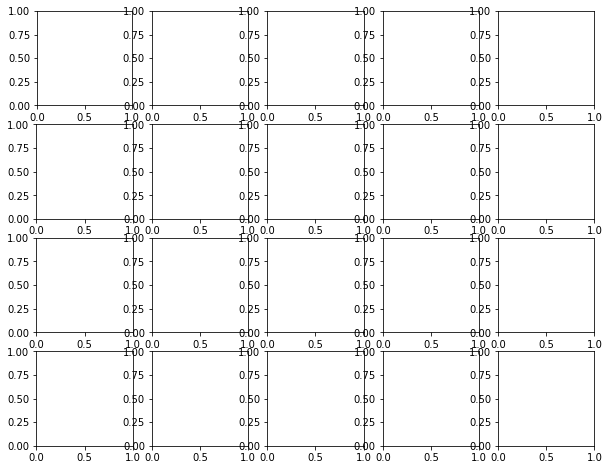

In [16]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    img = train_dataset[data_choice][idx]
    #print(img.shape)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
#def AddEmptyChannel(x):
#    x = np.expand_dims(x,axis=4)
#    return x

#X_train = reshapeData(x_train)
#Y_train = reshapeData(y_train)
#x_val = reshapeData(x_val)
#y_val = reshapeData(y_val)


#print(x_train.shape)
##X_train = np.expand_dims(x_train,axis=0)
#X_train = np.expand_dims(X_train,axis=4)
#print(X_train.shape)

#print(y_train.shape)
#Y_train = np.expand_dims(y_train,axis=0)
#Y_train = np.expand_dims(Y_train,axis=4)
#print(Y_train.shape)

#x_val = np.expand_dims(x_val, axis=0)
#x_val = np.expand_dims(x_val, axis=4)

#y_val = np.expand_dims(y_val, axis=0)
#y_val = np.expand_dims(y_val, axis=4)

In [17]:
# Construct the input layer with no definite frame size.
print(*x_train.shape[1:])
inp = layers.Input(shape=(None, *x_train.shape[2:]))
#inp = layers.Input(shape=(None, 100,100,1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    name="ConvLSTM2D_1",
    data_format="channels_last"
)(inp)

if 1:
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
        name="ConvLSTM2D_2",
        data_format="channels_last"
    )(x)

x = layers.BatchNormalization()(x)

if 0:
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=True,
        activation="relu",
        name="ConvLSTM2D_3",
        data_format="channels_last"
    )(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same",
    name="ConvLSTM3D",
    data_format="channels_last"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    #loss=keras.losses.mse, optimizer=keras.optimizers.Adam(1e-6),
    #loss=keras.losses.mse, optimizer=keras.optimizers.RMSprop(1e-6),
    #loss=keras.losses.mse, optimizer=keras.optimizers.SGD(1e-6),
    loss=keras.losses.mse, optimizer=keras.optimizers.SGD(),
)

14 100 100 1


In [21]:
#### Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=3)

# Define modifiable training hyperparameters.
epochs = 200
batch_size = batchsize

# Fit the model to the training data.
# round 1 = history
# round 2 = history2
history2 = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/200
1/1 - 81s - loss: 0.0414 - val_loss: 0.1192
Epoch 2/200
1/1 - 84s - loss: 0.0413 - val_loss: 0.1187
Epoch 3/200
1/1 - 84s - loss: 0.0412 - val_loss: 0.1183
Epoch 4/200
1/1 - 84s - loss: 0.0412 - val_loss: 0.1179
Epoch 5/200
1/1 - 83s - loss: 0.0410 - val_loss: 0.1174
Epoch 6/200
1/1 - 83s - loss: 0.0409 - val_loss: 0.1170
Epoch 7/200
1/1 - 83s - loss: 0.0408 - val_loss: 0.1165
Epoch 8/200
1/1 - 83s - loss: 0.0407 - val_loss: 0.1161
Epoch 9/200
1/1 - 83s - loss: 0.0406 - val_loss: 0.1157
Epoch 10/200
1/1 - 83s - loss: 0.0403 - val_loss: 0.1152
Epoch 11/200
1/1 - 83s - loss: 0.0402 - val_loss: 0.1148
Epoch 12/200
1/1 - 83s - loss: 0.0401 - val_loss: 0.1144
Epoch 13/200
1/1 - 83s - loss: 0.0400 - val_loss: 0.1140
Epoch 14/200
1/1 - 83s - loss: 0.0399 - val_loss: 0.1135
Epoch 15/200
1/1 - 83s - loss: 0.0398 - val_loss: 0.1131
Epoch 16/200
1/1 - 83s - loss: 0.0397 - val_loss: 0.1127
Epoch 17/200
1/1 - 83s - loss: 0.0396 - val_loss: 0.1123
Epoch 18/200
1/1 - 83s - loss: 0.0394 - 

1/1 - 83s - loss: 0.0286 - val_loss: 0.0738
Epoch 145/200
1/1 - 83s - loss: 0.0286 - val_loss: 0.0736
Epoch 146/200
1/1 - 83s - loss: 0.0285 - val_loss: 0.0734
Epoch 147/200
1/1 - 83s - loss: 0.0285 - val_loss: 0.0732
Epoch 148/200
1/1 - 83s - loss: 0.0284 - val_loss: 0.0730
Epoch 149/200
1/1 - 83s - loss: 0.0283 - val_loss: 0.0728
Epoch 150/200
1/1 - 83s - loss: 0.0282 - val_loss: 0.0726
Epoch 151/200
1/1 - 83s - loss: 0.0282 - val_loss: 0.0724
Epoch 152/200
1/1 - 83s - loss: 0.0281 - val_loss: 0.0722
Epoch 153/200
1/1 - 83s - loss: 0.0281 - val_loss: 0.0720
Epoch 154/200
1/1 - 83s - loss: 0.0280 - val_loss: 0.0717
Epoch 155/200
1/1 - 83s - loss: 0.0280 - val_loss: 0.0715
Epoch 156/200
1/1 - 83s - loss: 0.0279 - val_loss: 0.0713
Epoch 157/200
1/1 - 83s - loss: 0.0278 - val_loss: 0.0711
Epoch 158/200
1/1 - 83s - loss: 0.0278 - val_loss: 0.0709
Epoch 159/200
1/1 - 83s - loss: 0.0277 - val_loss: 0.0708
Epoch 160/200
1/1 - 83s - loss: 0.0276 - val_loss: 0.0706
Epoch 161/200
1/1 - 83s - lo

In [22]:
model.save('../models/cnnlstm4')

INFO:tensorflow:Assets written to: ../models/cnnlstm4/assets


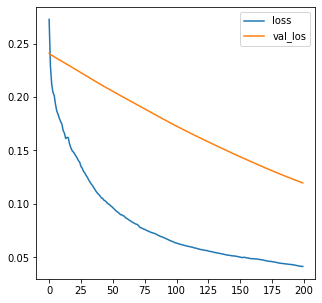

In [20]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_los')
ax.legend()

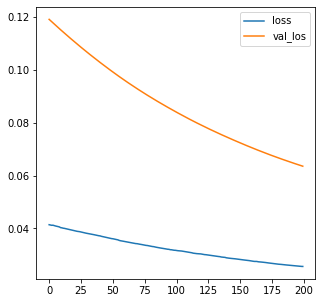

In [24]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(history2.history['loss'], label='loss')
ax.plot(history2.history['val_loss'], label='val_los')
ax.legend()

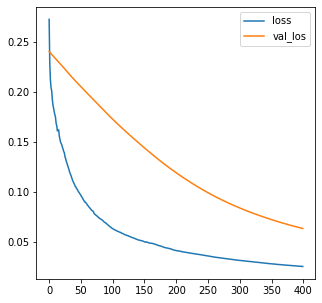

In [28]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(joint_loss, label='loss')
ax.plot(joint_valloss, label='val_los')
ax.legend()

In [26]:
joint_loss = history.history['loss'] + history2.history['loss']
joint_valloss = history.history['val_loss'] + history2.history['val_loss']

In [39]:
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(reshapeData(frames))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = reshapeData(new_prediction) 

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

ValueError: in user code:

    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1030 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:421 call
        inputs, training=training, mask=mask)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:556 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/layers/recurrent.py:668 __call__
        return super(RNN, self).__call__(inputs, **kwargs)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/input_spec.py:219 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer ConvLSTM2D_1 is incompatible with the layer: expected ndim=5, found ndim=3. Full shape received: (None, 10, 100)
